# Evaluating Llama 2 70b Chat - binary

In [1]:
import random
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Llama2_70B_Chat = prompter_factory(prompter_type="binary",
                                   client=client,
                                   model="meta-llama/Llama-2-70b-chat-hf")

In [6]:
prompt = "You are a helpful model diagnosing diseases based on Doctor - Patient conversations. \
            Given a conversation, you should determine whether the patient has symptoms or not. \
            Some symptoms will be mentioned but will not apply to the patient. It is important \
            that you only consider symptoms that are experienced by the patient. \
            An example of a patient mentioning a symptom that does not apply to them is: \
            'P: My daughter is having fevers and barely sleeps'. Your answer should be \
            'No'. It is also important that you only consider explicit mentions of symptoms. \
            An example of a patient not explicitly mentioning a symptom is: \
            'D: You need to get an MRI as soon as possible. P: OK. D: Alright.' \
            Your answer should be: 'No'. \
            You should refrain from answering yes if you are not certain. If you are not \
            certain, your answer should be: 'No'. \
            Are any medical symptoms mentioned in the transcript?"

In [7]:
results_llama2_70B_chat = Llama2_70B_Chat.generate(df=data, prompt=prompt)

binary task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 0:   0%|          | 0/550 [00:00<?, ?it/s]

binary task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 392,884: 100%|██████████| 550/550 [00:37<00:00, 14.65it/s]


## Model evaluation

Bootstrapping Llama2_70B_Chat: 100%|██████████| 1000/1000 [00:04<00:00, 243.37it/s]


accuracy: 0.8634 (0.834-0.8916 95% CI)
precision: 0.8508 (0.8173-0.8834 95% CI)
recall: 0.981 (0.9657-0.9944 95% CI)
f1: 0.9112 (0.8901-0.9305 95% CI)
Unstructured output ratio: 0.0821 (0.0618-0.1037 95% CI)


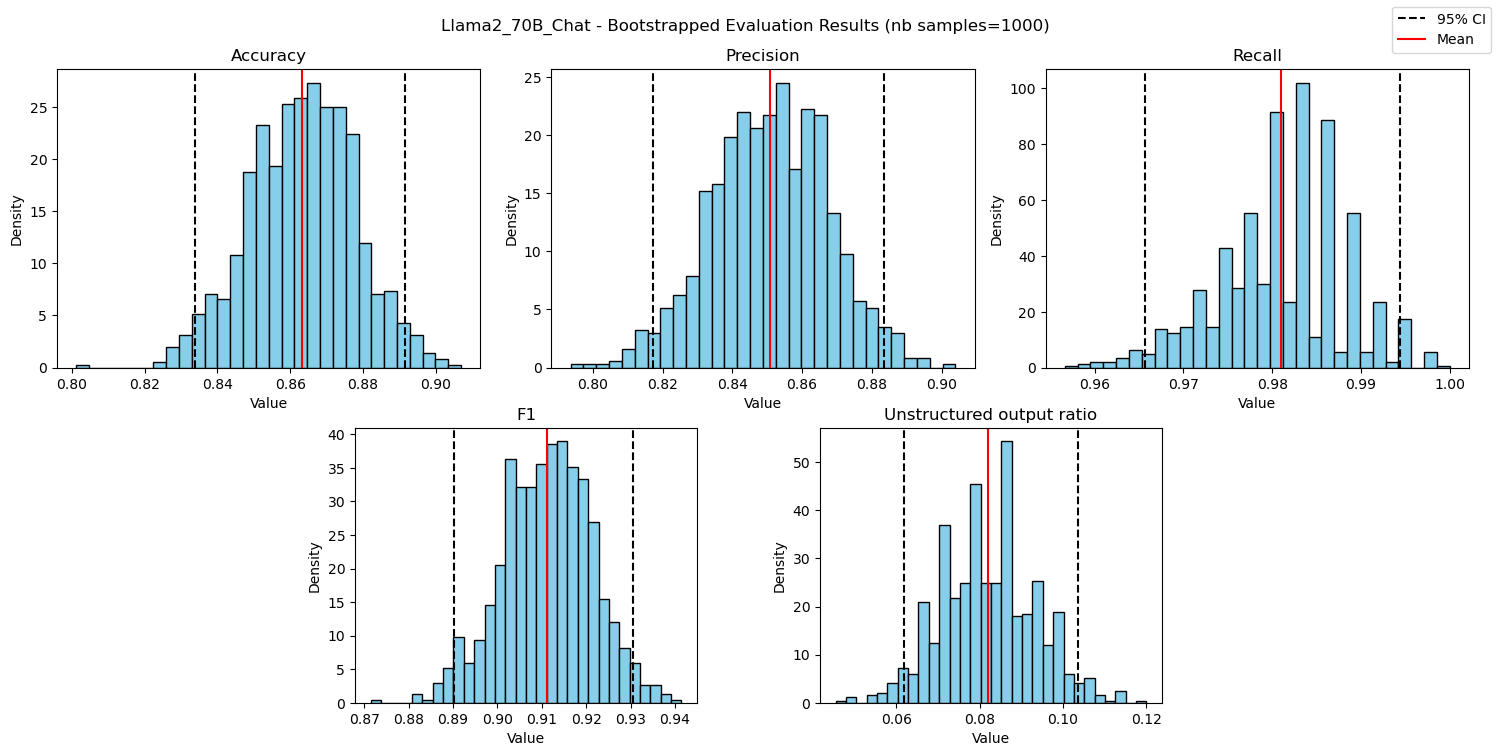

In [8]:
scorer_llama2_70B_chat = scorer_factory(scorer_type="binary", data=data, results=results_llama2_70B_chat, model_name="Llama2_70B_Chat")
scorer_llama2_70B_chat.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 310,584: 100%|██████████| 550/550 [01:09<00:00,  7.92it/s]
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 309,174: 100%|██████████| 550/550 [00:43<00:00, 12.51it/s]
Bootstrapping Llama2_70B_Chat: 100%|██████████| 1000/1000 [00:03<00:00, 250.10it/s]


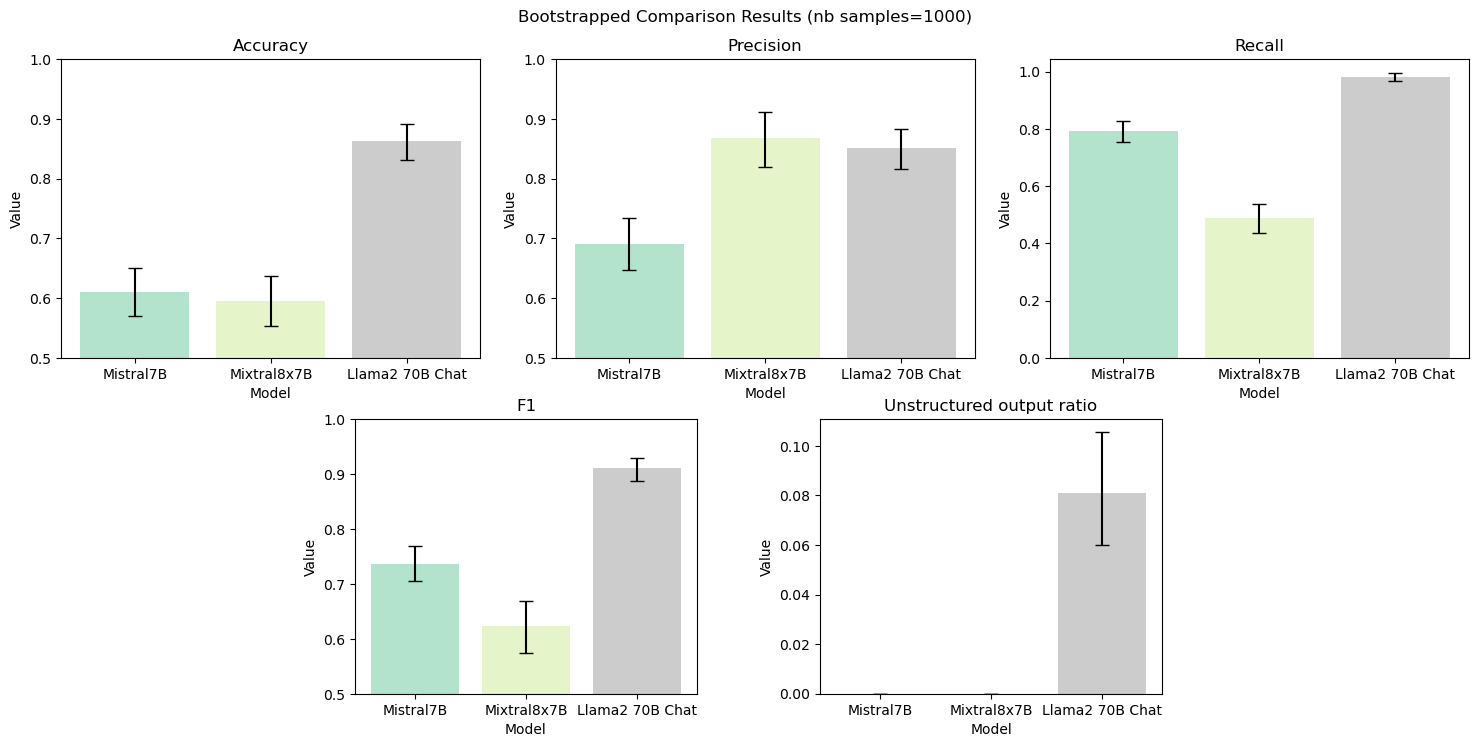

In [9]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b, model_name="Mistral 7B")

Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b, model_name="Mixtral 8x7B")

dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b, "Llama2 70B Chat": scorer_llama2_70B_chat}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [10]:
df_llama2_70B_chat_error = scorer_llama2_70B_chat.get_error_dataframe()

In [11]:
df_llama2_70B_chat_error['Pred status'].value_counts(dropna=False)

Pred status
True     62
NaN      45
False     7
Name: count, dtype: int64

In [12]:
df_llama2_70B_chat_error[df_llama2_70B_chat_error["Pred status"].isnull()]["Pred output"]

6        Based on the conversation provided, the pati...
19       Based on the conversation, there are no expl...
30       Based on the conversation provided, there ar...
34       Based on the conversation provided, there ar...
43       Based on the conversation between the doctor...
74       Based on the conversation provided, there ar...
81       Based on the conversation between the doctor...
83       Based on the conversation between the doctor...
85       Based on the conversation provided, there ar...
141      Based on the conversation provided, there ar...
142      Based on the conversation provided, there ar...
162      Based on the conversation between the doctor...
174      Based on the conversation provided, there ar...
222      Based on the conversation between the doctor...
236      Based on the conversation between the doctor...
246      Based on the conversation between the doctor...
264      Based on the conversation provided, there ar...
265      Based on the conversat

In [13]:
selected_columns = df_llama2_70B_chat_error.columns[:df_llama2_70B_chat_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"] + ["Pred output"]
df_llama2_70B_chat_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status,Pred output
count,114,47,11,114,114,31,114,16,16,10,114,26,69,114
unique,114,2,10,47,2,17,47,8,6,2,2,16,2,114
top,"P: Uhm, so my younger sister had a sore throat...",Negative,Other,RES0168.txt,Negative,Other,RES0168.txt,None;Other,NONE,Negative;Positive,False,pain,True,"Based on the conversation provided, the pati..."
freq,1,37,2,5,83,12,5,7,9,7,88,6,62,1


In [14]:
unique_values = df_llama2_70B_chat_error["Symptom Status_bd"].unique()
print(unique_values)


['Positive' 'Negative' nan]


In [15]:
df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Output: {row['Pred status']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
concatenated_list = df_llama2_70B_chat_error["Concatenated"].tolist()

/var/folders/my/zbw_v3fd3l554w11sc2ks3xc0000gn/T/ipykernel_66674/2039514407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(


In [16]:
random.shuffle(concatenated_list)
print(concatenated_list[0])

index: 336

Context: D: OK. And are you up to date with your immunizations?

P: Yes.

D: Yeah, OK. Any allergies?

P: Uh, no, not that I know of.

D: OK. Any family history of lung or heart conditions?

P: Uhm, I think, uh my father, he died of a heart attack in his 60s.

D: OK, OK, any musculoskeletal issues?

P: Uhm, no, I don't think so. 

D: No. Uhm, how about autoimmune conditions?

P: No, not that I know of.

D: Any cancers?

P: Uh, I think, my, my mother had some skin cancer, but the ones that, she didn't need any surgery, they just zapped them off.

D: OK. Uhm and do you smoke?

P: No, I've never smoked?


Model Output: True


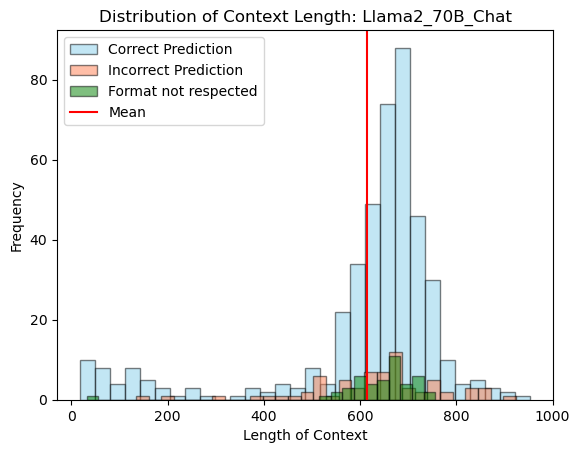

In [17]:
scorer_llama2_70B_chat.display_length_distribution()